In [1]:
import sys
sys.path.append('../')
from deep_rl.gridworld import ReachGridWorld, PickGridWorld, PORGBEnv, GoalManager, ScaleObsEnv
from deep_rl.network import *
from deep_rl.utils import *
import os
import random
import argparse
import dill
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from collections import Counter, namedtuple
from IPython.display import display
from PIL import Image
from pathlib import Path
from IPython.core.debugger import Tracer

def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)

set_seed(0) # set seed 

class GridDrawer:                           
    def __init__(self, color_list):
        self.color_list = np.asarray(color_list)

    # input: a 2-d index matrix
    # output: a 2-d rgb matrix
    def draw(self, indices, repeat=16):
        return np.uint8(255 * np.array(self.color_list[indices, :]).repeat(repeat, 0).repeat(repeat, 1))
    
# this is my color list
color_map = dict([
    #*[('grey-{}'.format(v), plt.cm.Greys(0.1 * v)) for v in range(1, 20)],
    *[('purple-{}'.format(v), plt.cm.Purples(0.05 * v)) for v in range(1, 20)],
    *[('blue-{}'.format(v), plt.cm.Blues(0.05 * v)) for v in range(1, 20)],
    *[('green-{}'.format(v), plt.cm.Greens(0.05 * v)) for v in range(1, 20)],
    *[('orange-{}'.format(v), plt.cm.Oranges(0.05 * v)) for v in range(1, 20)],
    *[('red-{}'.format(v), plt.cm.Reds(0.05 * v)) for v in range(1, 20)],
])

color_list = list(color_map.values())
shuffle(color_list)
color_list = [plt.cm.Greys(0.9)] + [plt.cm.Greys(0.5)] + color_list
drawer = GridDrawer(color_list)

visualization_map = dict([
    ('G', 0), # goal
    ('#', 1),
    *[(str(i), i + 2) for i in range(0, 100)],
])

def imshow(img):
    display(Image.fromarray(np.asarray(img).astype(np.uint8)))

def fload(fn, ftype):
    if ftype == 'json':
        with open(fn) as f:
            return json.load(f)
    elif ftype == 'pkl':
        with open(fn, 'rb') as f:
            return dill.load(f)
    elif ftype == 'png':
        raise NotImplementedError
    else:
        raise Exception('cannot read this data type: {}'.format(ftype))
    
def fsave(data, fn, ftype):
    dirname = os.path.dirname(fn)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    if ftype == 'json':
        with open(fn, 'w') as f:
            json.dump(data, f)
    elif ftype == 'pkl':
        with open(fn, 'wb') as f:
            dill.dump(data, f)    
    elif ftype == 'png':
        Image.fromarray(data).save(fn)
    else:
        raise Exception('unsupported file type: {}'.format(ftype))
        
GoalConfig = namedtuple('GoalConfig', ['map_name', 'n_goal', 'min_dis'])  

# multitask NMF from: https://ieeexplore.ieee.org/document/6939673
class MTNMF:
    def __init__(
        self, 
        n_components, 
        l1_ratio=0.0, 
        max_iter=200, 
        tol=0.0001, 
        normalize=False,
        normalize_axis=0,
    ):
        self.n_components = n_components
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize
        self.normalize_axis = normalize_axis

    def loss(self, X, A, S):
        return 0.5 * ((X - np.matmul(A, S)) ** 2).sum() + self.l1_ratio * S.sum()
        
    # input: a stack of observed data X_1, ..., X_K
    # output: S, A_1, ..., A_K
    def fit(self, X):
        K, N, M = X.shape
        A = np.random.rand(K, N, self.n_components)
        S = np.random.rand(self.n_components, M)
        prev_loss = np.inf
        cur_loss = None
        for i in range(self.max_iter):
            A_T = A.transpose(0, 2, 1)
            new_S = S * (np.matmul(A_T, X).sum(0)) / (np.matmul(np.matmul(A_T, A), S).sum(0) + K * self.l1_ratio * np.ones((self.n_components, M)))
            if self.normalize: 
                new_S = new_S / new_S.sum(self.normalize_axis, keepdims=True)
            S = new_S
            new_A = A * np.matmul(X, S.T) / np.matmul(np.matmul(A, S), S.T)
            if self.normalize: 
                new_A = new_A / new_A.sum(self.normalize_axis + 1, keepdims=True)
            A = new_A
            cur_loss = self.loss(X, A, S)
            if i % 100 == 0: print('NMF loss:', cur_loss)
            if abs(cur_loss - prev_loss) < self.tol: break
            prev_loss = cur_loss # update loss
        return A, S, {'loss': cur_loss, 'iter': i}

def rollout(env, idx, policy=None, horizon=100, epsilon=0.1):
    states = []
    returns = 0.0
    done = False
    #normalizer = ImageNormalizer()
    state = env.reset(sample_obj_pos=False) # very important!
    info = dict(task_id=[idx])
    for _ in range(horizon):
        states.append(state)
        if policy is None:
            action = env.action_space.sample()
        else:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = policy([state], info)['a'][0].cpu().detach().numpy()
        state, r, done, _ = env.step(action) # note that info is not used
        returns += r
        if done: break
    return states, returns

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


# MTNMF (Nineroom)

In [2]:
set_seed(0)

def get_img(env, abs_list):
    size = (env.unwrapped.row, env.unwrapped.col)
    indices = np.zeros(size, dtype=np.int64)
    k = 0
    for i in range(size[0]):
        for j in range(size[1]):
            if (i, j) in env.unwrapped.default_obj_pos[0]: # object position
                indices[i, j] = 0
            elif env.unwrapped.m[i][j] == '#':
                indices[i, j] = 1
            else:
                indices[i, j] = visualization_map[str(2 + abs_list[k])]
                k += 1

    img = drawer.draw(indices)
    return img

def get_visualization_env():
    with open('../data/env_configs/pick/nineroom/nineroom.8', 'rb') as f:
        env_config = dill.load(f)
    print(env_config)
    env = ScaleObsEnv(
        PickGridWorld(
            **env_config,
            min_dis=1,
            window=1,
            task_length=1,
            seed=0,
        ),
        2,
    )
    env.reset(sample_obj_pos=False)
    positions = env.unwrapped.pos_candidates
    states = []
    for pos in positions:
        o, _, _, _ = env.teleport(*pos)
        states.append(o)
    print('states shape:', len(states))
    return env, states

## Visualize all states

Automatic pdb calling has been turned ON
{'map_names': ['map49'], 'train_combos': [(0, 8)], 'test_combos': [(0, 0)], 'num_obj_types': 9, 'obj_pos': [[(14, 1), (9, 9), (3, 13), (9, 1), (1, 9), (4, 2), (12, 9), (13, 12), (6, 13)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 8)]
test: [(0, 0)]
states shape: 152
(152, 5)
(152, 5)
(152, 5)
(152, 5)
(152, 5)
(152, 5)
(152, 5)
(152, 5)
NMF loss: 380.10323753334484
NMF loss: 362.0106982444329
NMF loss: 326.07816764513706
NMF loss: 281.82365402940786
NMF loss: 252.51345863153045
NMF loss: 237.37210325605147
NMF loss: 228.416060336711
NMF loss: 221.70443899916273
NMF loss: 215.729999477217
NMF loss: 209.7427206654534
NMF loss: 203.01807388445232
NMF loss: 194.92349715893192
NMF loss: 185.20274526262904
NMF loss: 174.19613970768037
NMF 

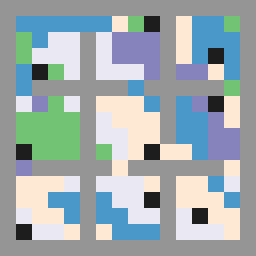

In [35]:
%pdb on
n_abs = 5
l1_ratio = 0.0 # this is currently not working... since alpha is not set
feat_dim = 512
action_dim = 5
horizon = 100
n_trajs = 10 #30
scale = 2
n_objs = 9
epsilon = 0.0
normalize = True

def get_expert(weight_path, action_dim):
    visual_body = TSAMiniConvBody(
        2 + n_objs, 
        feature_dim=feat_dim,
        scale=scale,
        #gate=F.softplus,
    )
    expert = CategoricalActorCriticNet(
        n_objs,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    return expert

set_seed(0)

expert_dict = {
    0: '../log/pick.mask.nineroom.0.min_dis-1/tsa.baseline.n_abs-512/relu/0.190327-232308/models/step-491520-mean-10.70',
    1: '../log/pick.mask.nineroom.1.min_dis-1/tsa.baseline.n_abs-512/relu/1.190327-235057/models/step-491520-mean-10.84',
    2: '../log/pick.mask.nineroom.2.min_dis-1/tsa.baseline.n_abs-512/relu/1.190328-000958/models/step-491520-mean-10.86',
    3: '../log/pick.mask.nineroom.3.min_dis-1/tsa.baseline.n_abs-512/relu/2.190328-003751/models/step-491520-mean-10.71',
    4: '../log/pick.mask.nineroom.4.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-005600/models/step-491520-mean-10.81',
    5: '../log/pick.mask.nineroom.5.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-011456/models/step-491520-mean-10.78',
    6: '../log/pick.mask.nineroom.6.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-014223/models/step-491520-mean-10.82',
    7: '../log/pick.mask.nineroom.7.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-020127/models/step-491520-mean-10.84',
}

env, states = get_visualization_env()

experts = dict()

for goal_idx, weight_path in expert_dict.items():
    experts[goal_idx] = get_expert(weight_path, action_dim)

pvs = []

for goal_idx in expert_dict:
    cur_infos = {'task_id': [goal_idx] * len(states)}
    pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    print(pv.shape)
    pv = pv.reshape(pv.shape[0], -1)
    pvs.append(pv)

pvs = np.stack(pvs, 0)
A, S, info = MTNMF(n_abs, max_iter=5000, l1_ratio=l1_ratio, normalize=normalize).fit(pvs.transpose(0, 2, 1))

abs_list = S.T.argmax(1)
img = get_img(env, abs_list)
imshow(img)

#print((S.T).sum(1))


## Generate from sampling (C5)

In [ ]:
%pdb on
n_abs = 20
l1_ratio = 0.0 # this is currently not working... since alpha is not set
feat_dim = 512
action_dim = 5
horizon = 100
n_trajs = 20 #30
scale = 2
n_objs = 9
epsilon = 0.2
normalize = False

# eps: 10: 341 - xxx, 20: 641 - 3831
# mix: 10: 549 - 3317

def get_expert(weight_path, action_dim):
    visual_body = TSAMiniConvBody(
        2 + n_objs, 
        feature_dim=feat_dim,
        scale=scale,
        #gate=F.softplus,
    )
    expert = CategoricalActorCriticNet(
        n_objs,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    return expert

set_seed(0)

expert_dict = {
    0: '../log/pick.mask.nineroom.0.min_dis-1/tsa.baseline.n_abs-512/relu/0.190327-232308/models/step-491520-mean-10.70',
    1: '../log/pick.mask.nineroom.1.min_dis-1/tsa.baseline.n_abs-512/relu/1.190327-235057/models/step-491520-mean-10.84',
    2: '../log/pick.mask.nineroom.2.min_dis-1/tsa.baseline.n_abs-512/relu/1.190328-000958/models/step-491520-mean-10.86',
    3: '../log/pick.mask.nineroom.3.min_dis-1/tsa.baseline.n_abs-512/relu/2.190328-003751/models/step-491520-mean-10.71',
    4: '../log/pick.mask.nineroom.4.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-005600/models/step-491520-mean-10.81',
    5: '../log/pick.mask.nineroom.5.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-011456/models/step-491520-mean-10.78',
    6: '../log/pick.mask.nineroom.6.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-014223/models/step-491520-mean-10.82',
    7: '../log/pick.mask.nineroom.7.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-020127/models/step-491520-mean-10.84',
}

envs = dict()
for i in range(8):
    with open('../data/env_configs/pick/nineroom/nineroom.{}'.format(i), 'rb') as f:
        env_config = dill.load(f)
    print(env_config)
    envs[i] = ScaleObsEnv(
        PickGridWorld(
            **env_config,
            min_dis=1,
            window=1,
            task_length=1,
            seed=0,
        ),
        2,
    )

states = []
experts = dict()

for goal_idx, weight_path in expert_dict.items():
    returns = []
    experts[goal_idx] = get_expert(weight_path, action_dim)
    for _ in range(n_trajs):
        rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
                                                  experts[goal_idx], horizon=horizon, epsilon=epsilon)
        states.append(rollout_states)
        returns.append(rollout_returns)
#     for _ in range(n_trajs // 2):
#         rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
#                                                   experts[goal_idx], horizon=horizon)
#         states.append(rollout_states)
#         returns.append(rollout_returns)
#     for _ in range(n_trajs - (n_trajs // 2)):
#         rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
#                                                   None, horizon=horizon)
#         states.append(rollout_states)
    if returns: print('goal: {}, mean return: {}'.format(goal_idx, np.mean(returns)))
states = np.concatenate(states)
print('states shape:', states.shape)

pvs = []

for goal_idx in expert_dict:
    cur_infos = {'task_id': [goal_idx] * len(states)}
    pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    print(pv.shape)
    pv = pv.reshape(pv.shape[0], -1)
    pvs.append(pv)

pvs = np.stack(pvs, 0)
A, S, info = MTNMF(n_abs, max_iter=5000, l1_ratio=l1_ratio, normalize=normalize).fit(pvs.transpose(0, 2, 1))
print(pvs.shape)
save_path = '../data/nmf_sample/pick/nineroom/split.n.{}-{}-{}'.format(n_trajs, epsilon, n_abs)
print('save: {}'.format(save_path))

print(S.T)

# fsave(
#     dict(
#         abs=S.T,
#         policies=list(pvs),
#         states=[states for _ in range(len(pvs))],
#         infos=list([[{'task_id': i} for _ in range(len(states))] for i in experts.keys()]),
#     ),
#     save_path,
#     'pkl',
# )

## Generate from sampling

In [4]:
%pdb on
n_abs = 20
l1_ratio = 0.0 # this is currently not working... since alpha is not set
feat_dim = 512
action_dim = 5
horizon = 100
n_trajs = 10 #30
scale = 2
n_objs = 9
epsilon = 0.0
normalize = False

# eps: 10: 341 - xxx, 20: 641 - 3831
# mix: 10: 549 - 3317

def get_expert(weight_path, action_dim):
    visual_body = TSAMiniConvBody(
        2 + n_objs, 
        feature_dim=feat_dim,
        scale=scale,
        #gate=F.softplus,
    )
    expert = CategoricalActorCriticNet(
        n_objs,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    return expert

set_seed(0)

expert_dict = {
    0: '../log/pick.mask.nineroom.0.min_dis-1/tsa.baseline.n_abs-512/relu/0.190327-232308/models/step-491520-mean-10.70',
    1: '../log/pick.mask.nineroom.1.min_dis-1/tsa.baseline.n_abs-512/relu/1.190327-235057/models/step-491520-mean-10.84',
    2: '../log/pick.mask.nineroom.2.min_dis-1/tsa.baseline.n_abs-512/relu/1.190328-000958/models/step-491520-mean-10.86',
    3: '../log/pick.mask.nineroom.3.min_dis-1/tsa.baseline.n_abs-512/relu/2.190328-003751/models/step-491520-mean-10.71',
    4: '../log/pick.mask.nineroom.4.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-005600/models/step-491520-mean-10.81',
    5: '../log/pick.mask.nineroom.5.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-011456/models/step-491520-mean-10.78',
    6: '../log/pick.mask.nineroom.6.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-014223/models/step-491520-mean-10.82',
    7: '../log/pick.mask.nineroom.7.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-020127/models/step-491520-mean-10.84',
}

envs = dict()
for i in range(8):
    with open('../data/env_configs/pick/nineroom/nineroom.{}'.format(i), 'rb') as f:
        env_config = dill.load(f)
    print(env_config)
    envs[i] = ScaleObsEnv(
        PickGridWorld(
            **env_config,
            min_dis=1,
            window=1,
            task_length=1,
            seed=0,
        ),
        2,
    )

states = []
experts = dict()

for goal_idx, weight_path in expert_dict.items():
    returns = []
    experts[goal_idx] = get_expert(weight_path, action_dim)
#     for _ in range(n_trajs):
#         rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
#                                                   experts[goal_idx], horizon=horizon, epsilon=epsilon)
#         states.append(rollout_states)
#         returns.append(rollout_returns)
    for _ in range(n_trajs // 2):
        rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
                                                  experts[goal_idx], horizon=horizon)
        states.append(rollout_states)
        returns.append(rollout_returns)
    for _ in range(n_trajs - (n_trajs // 2)):
        rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
                                                  None, horizon=horizon)
        states.append(rollout_states)
    if returns: print('goal: {}, mean return: {}'.format(goal_idx, np.mean(returns)))
states = np.concatenate(states)
print('states shape:', states.shape)

pvs = []

for goal_idx in expert_dict:
    cur_infos = {'task_id': [goal_idx] * len(states)}
    pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    print(pv.shape)
    pv = pv.reshape(pv.shape[0], -1)
    pvs.append(pv)

pvs = np.stack(pvs, 0)
A, S, info = MTNMF(n_abs, max_iter=5000, tol=1e-5, l1_ratio=l1_ratio, normalize=normalize).fit(pvs.transpose(0, 2, 1))
print(pvs.shape)
save_path = '../data/nmf_sample/pick/nineroom/split.new.{}-{}-{}'.format(n_trajs, epsilon, n_abs)
print('save: {}'.format(save_path))

print(S.T)

fsave(
    dict(
        abs=S.T,
        policies=list(pvs),
        actors=list(A),
        states=[states for _ in range(len(pvs))],
        infos=list([[{'task_id': i} for _ in range(len(states))] for i in experts.keys()]),
    ),
    save_path,
    'pkl',
)

Automatic pdb calling has been turned ON
{'map_names': ['map49'], 'train_combos': [(0, 0)], 'test_combos': [(0, 0)], 'num_obj_types': 9, 'obj_pos': [[(14, 1), (9, 9), (3, 13), (9, 1), (1, 9), (4, 2), (12, 9), (13, 12), (6, 13)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 0)]
test: [(0, 0)]
{'map_names': ['map49'], 'train_combos': [(0, 1)], 'test_combos': [(0, 0)], 'num_obj_types': 9, 'obj_pos': [[(14, 1), (9, 9), (3, 13), (9, 1), (1, 9), (4, 2), (12, 9), (13, 12), (6, 13)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 1)]
test: [(0, 0)]
{'map_names': ['map49'], 'tra

# Dictionary Learning

In [58]:
%pdb on
n_abs = 8
l1_ratio = 0.0 # this is currently not working... since alpha is not set
feat_dim = 512
action_dim = 5
horizon = 100
n_trajs = 20 #30
scale = 2
n_objs = 9
epsilon = 0.2
normalize = True

# eps: 10: 341 - xxx, 20: 641 - 3831
# mix: 10: 549 - 3317

def get_expert(weight_path, action_dim):
    visual_body = TSAMiniConvBody(
        2 + n_objs, 
        feature_dim=feat_dim,
        scale=scale,
        #gate=F.softplus,
    )
    expert = CategoricalActorCriticNet(
        n_objs,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    return expert

set_seed(0)

expert_dict = {
    0: '../log/pick.mask.nineroom.0.min_dis-1/tsa.baseline.n_abs-512/relu/0.190327-232308/models/step-491520-mean-10.70',
    1: '../log/pick.mask.nineroom.1.min_dis-1/tsa.baseline.n_abs-512/relu/1.190327-235057/models/step-491520-mean-10.84',
    2: '../log/pick.mask.nineroom.2.min_dis-1/tsa.baseline.n_abs-512/relu/1.190328-000958/models/step-491520-mean-10.86',
    3: '../log/pick.mask.nineroom.3.min_dis-1/tsa.baseline.n_abs-512/relu/2.190328-003751/models/step-491520-mean-10.71',
    4: '../log/pick.mask.nineroom.4.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-005600/models/step-491520-mean-10.81',
    5: '../log/pick.mask.nineroom.5.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-011456/models/step-491520-mean-10.78',
    6: '../log/pick.mask.nineroom.6.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-014223/models/step-491520-mean-10.82',
    7: '../log/pick.mask.nineroom.7.min_dis-1/tsa.baseline.n_abs-512/relu/0.190328-020127/models/step-491520-mean-10.84',
}

envs = dict()
for i in range(8):
    with open('../data/env_configs/pick/nineroom/nineroom.{}'.format(i), 'rb') as f:
        env_config = dill.load(f)
    print(env_config)
    envs[i] = ScaleObsEnv(
        PickGridWorld(
            **env_config,
            min_dis=1,
            window=1,
            task_length=1,
            seed=0,
        ),
        2,
    )

states = []
experts = dict()

for goal_idx, weight_path in expert_dict.items():
    returns = []
    experts[goal_idx] = get_expert(weight_path, action_dim)
    for _ in range(n_trajs):
        rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
                                                  experts[goal_idx], horizon=horizon, epsilon=epsilon)
        states.append(rollout_states)
        returns.append(rollout_returns)
#     for _ in range(n_trajs // 2):
#         rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
#                                                   experts[goal_idx], horizon=horizon)
#         states.append(rollout_states)
#         returns.append(rollout_returns)
#     for _ in range(n_trajs - (n_trajs // 2)):
#         rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, 
#                                                   None, horizon=horizon)
#         states.append(rollout_states)
    if returns: print('goal: {}, mean return: {}'.format(goal_idx, np.mean(returns)))
states = np.concatenate(states)
print('states shape:', states.shape)

pvs = []

for goal_idx in expert_dict:
    cur_infos = {'task_id': [goal_idx] * len(states)}
    pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    print(pv.shape)
    pv = pv.reshape(pv.shape[0], -1)
    pvs.append(pv)

pvs = np.stack(pvs, 0)
S, D, info = MTNMF(n_abs, max_iter=5000, l1_ratio=l1_ratio, normalize=normalize, normalize_axis=1).fit(pvs)
print(pvs.shape)
save_path = '../data/nmf_sample/pick/nineroom/split.n.{}-{}-{}'.format(n_trajs, epsilon, n_abs)
print('save: {}'.format(save_path))

print(D)

# fsave(
#     dict(
#         abs=S.T,
#         policies=list(pvs),
#         states=[states for _ in range(len(pvs))],
#         infos=list([[{'task_id': i} for _ in range(len(states))] for i in experts.keys()]),
#     ),
#     save_path,
#     'pkl',
# )

Automatic pdb calling has been turned ON
{'map_names': ['map49'], 'train_combos': [(0, 0)], 'test_combos': [(0, 0)], 'num_obj_types': 9, 'obj_pos': [[(14, 1), (9, 9), (3, 13), (9, 1), (1, 9), (4, 2), (12, 9), (13, 12), (6, 13)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 0)]
test: [(0, 0)]
{'map_names': ['map49'], 'train_combos': [(0, 1)], 'test_combos': [(0, 0)], 'num_obj_types': 9, 'obj_pos': [[(14, 1), (9, 9), (3, 13), (9, 1), (1, 9), (4, 2), (12, 9), (13, 12), (6, 13)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',)), (5, ('F',)), (6, ('G',)), (7, ('H',)), (8, ('I',))]
train: [(0, 1)]
test: [(0, 0)]
{'map_names': ['map49'], 'tra

In [53]:
np.set_printoptions(precision=1)
print(D)

[[2.2e-005 1.2e-005 4.3e-010 3.8e-001 3.2e-200]
 [5.0e-005 1.6e-004 4.2e-001 1.9e-011 3.5e-005]
 [9.6e-005 1.2e-004 1.9e-012 5.2e-004 1.4e-001]
 [6.1e-001 7.6e-024 2.0e-004 1.5e-009 9.9e-082]
 [2.8e-027 3.6e-001 1.3e-004 1.3e-004 8.1e-060]]


# MTNMF (Fourroom)

In [3]:
action_dim = 5
scale=2
n_objs = 4

set_seed(0)

def get_img(env, abs_list):
    size = (env.unwrapped.row, env.unwrapped.col)
    indices = np.zeros(size, dtype=np.int64)
    k = 0
    for i in range(size[0]):
        for j in range(size[1]):
            if (i, j) in env.unwrapped.default_obj_pos[0]: # object position
                indices[i, j] = 0
            elif env.unwrapped.m[i][j] == '#':
                indices[i, j] = 1
            else:
                indices[i, j] = visualization_map[str(2 + abs_list[k])]
                k += 1

    img = drawer.draw(indices)
    return img

def get_expert(weight_path, action_dim, feat_dim=512):
    visual_body = TSAMiniMiniConvBody(
        2 + n_objs, 
        feature_dim=feat_dim,
        scale=scale,
        gate=F.softplus,
    )
    expert = CategoricalActorCriticNet(
        n_objs,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    #weight_dict = expert.state_dict()
    #loaded_weight_dict = {k: v for k, v in torch.load(
    #    weight_path,
    #    map_location=lambda storage, loc: storage)['network'].items()
    #    if k in weight_dict}
    #weight_dict.update(loaded_weight_dict)
    #expert.load_state_dict(weight_dict)
    expert.load_state_dict(torch.load(weight_path, map_location=lambda storage, loc: storage)['network'])
    return expert

def get_visualization_env():
    with open('../data/env_configs/pick/fourroom/fourroom.3', 'rb') as f:
        env_config = dill.load(f)
    print(env_config)
    env = ScaleObsEnv(
        PickGridWorld(
            **env_config,
            min_dis=1,
            window=1,
            task_length=1,
            seed=0,
        ),
        2,
    )
    env.reset(sample_obj_pos=False)
    positions = env.unwrapped.pos_candidates
    states = []
    for pos in positions:
        o, _, _, _ = env.teleport(*pos)
        states.append(o)
    print('states shape:', len(states))
    return env, states

## Visualize for all states

Automatic pdb calling has been turned ON
{'map_names': ['fourroom'], 'train_combos': [(0, 3)], 'test_combos': [(0, 3)], 'num_obj_types': 4, 'obj_pos': [[(1, 1), (9, 1), (1, 9), (9, 9)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'fourroom')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',))]
train: [(0, 3)]
test: [(0, 3)]
states shape: 68
(68, 5)
(68, 5)
(68, 5)
NMF loss: 16.69140775941129
NMF loss: 2.2600365846322408
NMF loss: 2.2028002359008827
NMF loss: 2.1205691250175107
NMF loss: 2.0806840197212173


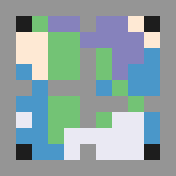

In [7]:
%pdb on
n_abs = 5
l1_ratio = 0.0 # this is currently not working... since alpha is not set
horizon = 100
n_trajs = 10
save_abs = False

set_seed(0)

expert_dict = {
    0: '../log/pick.mask.fourroom.0.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172629/models/step-92160-mean-10.86',
    1: '../log/pick.mask.fourroom.1.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172739/models/step-92160-mean-10.74',
    2: '../log/pick.mask.fourroom.2.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172847/models/step-92160-mean-10.81',
    #3: '../log/pick.mask.fourroom.3.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172956/models/step-92160-mean-10.87'
}

env, states = get_visualization_env()
    
decomposer = MTNMF(n_abs, max_iter=5000, tol=0.0001)

experts = dict()

for goal_idx, weight_path in expert_dict.items():
    experts[goal_idx] = get_expert(weight_path, action_dim)

pvs = []

for goal_idx in expert_dict:
    cur_infos = {'task_id': [goal_idx] * len(states)}
    pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    print(pv.shape)
    pv = pv.reshape(pv.shape[0], -1)
    pvs.append(pv)

pvs = np.stack(pvs, 0)
A, S, info = MTNMF(n_abs, max_iter=5000, l1_ratio=l1_ratio).fit(pvs.transpose(0, 2, 1))

abs_list = S.T.argmax(1)
img = get_img(env, abs_list)
imshow(img)

if save_abs:
    save_path = '../data/nmf_sample/pick/fourroom/split.full.{}'.format(n_abs)
    print('save: {}'.format(save_path))
    fsave(
        dict(
            abs=S.T,
            policies=list(pvs),
            states=[states for _ in range(len(pvs))],
            infos=list([[{'task_id': i} for _ in range(len(states))] for i in experts.keys()]),
        ),
        save_path,
        'pkl',
    )

## Visualize distilled states

{'map_names': ['fourroom'], 'train_combos': [(0, 3)], 'test_combos': [(0, 3)], 'num_obj_types': 4, 'obj_pos': [[(1, 1), (9, 1), (1, 9), (9, 9)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'fourroom')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',))]
train: [(0, 3)]
test: [(0, 3)]
states shape: 68


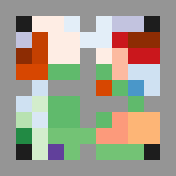

In [16]:
n_abs = 50
l1_ratio = 0.0

weight_dict = {
    20: '../log/pick.split.mix.10-20/nmf_sample.baseline.n_abs-20/20/0.190325-224016/models/step-720000-acc-10.71',
    50: '../log/pick.split.mix.10-50/nmf_sample.baseline.n_abs-50/50/0.190325-230619/models/step-1200000-acc-10.76',
    5: '../log/pick.split.mix.10-5/nmf_sample.baseline.n_abs-5/5/0.190325-230625/models/step-220800-acc-7.96',
}

env, states = get_visualization_env()
decomposer = MTNMF(n_abs, max_iter=5000, tol=0.0001)
expert = get_expert(weight_dict[n_abs], action_dim, feat_dim=n_abs)

abs_s = expert.network.phi_body(tensor(states))
abs_list = abs_s.argmax(1).detach().cpu().numpy()
img = get_img(env, abs_list)
imshow(img)

## Generate from sampling

In [4]:
%pdb on
n_abs = 50
l1_ratio = 0.0 # this is currently not working... since alpha is not set
feat_dim = 512
action_dim = 5
horizon = 100
n_trajs = 10 # 30
scale=2
n_objs = 4

def get_expert(weight_path, action_dim):
    visual_body = TSAMiniMiniConvBody(
        2 + n_objs, 
        feature_dim=feat_dim,
        scale=scale,
        gate=F.softplus,
    )
    expert = CategoricalActorCriticNet(
        n_objs,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    return expert

set_seed(0)

expert_dict = {
    #0: '../log/pick.mask.fourroom.0.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172629/models/step-92160-mean-10.86',
    1: '../log/pick.mask.fourroom.1.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172739/models/step-92160-mean-10.74',
    2: '../log/pick.mask.fourroom.2.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172847/models/step-92160-mean-10.81',
    3: '../log/pick.mask.fourroom.3.min_dis-1/tsa.baseline.n_abs-512/_/0.190325-172956/models/step-92160-mean-10.87'
}

envs = dict()
for i in range(1, 4):
    with open('../data/env_configs/pick/fourroom/fourroom.{}'.format(i), 'rb') as f:
        env_config = dill.load(f)
    print(env_config)
    envs[i] = ScaleObsEnv(
        PickGridWorld(
            **env_config,
            min_dis=1,
            window=1,
            task_length=1,
            seed=0,
        ),
        2,
    )

states = []
experts = dict()

for goal_idx, weight_path in expert_dict.items():
    returns = []
    experts[goal_idx] = get_expert(weight_path, action_dim)
#     for _ in range(n_trajs):
#         rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, experts[goal_idx], horizon=horizon)
#         states.append(rollout_states)
#         returns.append(rollout_returns)
    for _ in range(n_trajs // 2):
        rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, experts[goal_idx], horizon=horizon)
        states.append(rollout_states)
        returns.append(rollout_returns)
    for _ in range(n_trajs - (n_trajs // 2)):
        rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, None, horizon=horizon)
        states.append(rollout_states)
    if returns: print('goal: {}, mean return: {}'.format(goal_idx, np.mean(returns)))
states = np.concatenate(states)
print('states shape:', states.shape)

pvs = []

for goal_idx in expert_dict:
    cur_infos = {'task_id': [goal_idx] * len(states)}
    pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    print(pv.shape)
    pv = pv.reshape(pv.shape[0], -1)
    pvs.append(pv)

pvs = np.stack(pvs, 0)
A, S, info = MTNMF(n_abs, max_iter=5000, l1_ratio=l1_ratio).fit(pvs.transpose(0, 2, 1))
print(pvs.shape)
save_path = '../data/nmf_sample/pick/fourroom/split.eps.{}-{}'.format(n_trajs, n_abs)
print('save: {}'.format(save_path))

print(S.T)
print(S.min(), S.max(), S.mean())

# fsave(
#     dict(
#         abs=S.T,
#         policies=list(pvs),
#         states=[states for _ in range(len(pvs))],
#         infos=list([[{'task_id': i} for _ in range(len(states))] for i in experts.keys()]),
#     ),
#     save_path,
#     'pkl',
# )

Automatic pdb calling has been turned ON
{'map_names': ['fourroom'], 'train_combos': [(0, 1)], 'test_combos': [(0, 1)], 'num_obj_types': 4, 'obj_pos': [[(1, 1), (9, 1), (1, 9), (9, 9)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'fourroom')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',))]
train: [(0, 1)]
test: [(0, 1)]
{'map_names': ['fourroom'], 'train_combos': [(0, 2)], 'test_combos': [(0, 2)], 'num_obj_types': 4, 'obj_pos': [[(1, 1), (9, 1), (1, 9), (9, 9)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'fourroom')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',))]
train: [(0, 2)]
test: [(0, 2)]
{'map_names': ['fourroom'], 'train_combos': [(0, 3)], 'test_combos': [(0, 3)], 'num_obj_types': 4, 'obj_pos': [[(1, 1), (9, 1), (1, 9), (9, 9)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit d

# MTNMF (16x16)

In [18]:
%pdb on
n_abs = 20
l1_ratio = 0.0 # this is currently not working... since alpha is not set
feat_dim = 512
action_dim = 5
horizon = 100
n_trajs = 20
scale=2

def get_expert(weight_path, action_dim):
    visual_body = TSAMiniConvBody(
        7, 
        feature_dim=feat_dim,
        scale=scale)
    expert = CategoricalActorCriticNet(
        5,
        0, # state_dim
        action_dim,
        visual_body,
    )
    # load weight
    weight_dict = expert.state_dict()
    loaded_weight_dict = {k: v for k, v in torch.load(
        weight_path,
        map_location=lambda storage, loc: storage)['network'].items()
        if k in weight_dict}
    weight_dict.update(loaded_weight_dict)
    expert.load_state_dict(weight_dict)
    return expert

set_seed(0)

expert_dict = {
    1: '../log/pick.mask.map49.5-1.min_dis-1/tsa.baseline.n_abs-512/_/0.190323-000115/models/step-1945600-mean-10.81',
    2: '../log/pick.mask.map49.5-2.min_dis-1/tsa.baseline.n_abs-512/_/0.190323-002744/models/step-1945600-mean-10.72',
    3: '../log/pick.mask.map49.5-3.min_dis-1/tsa.baseline.n_abs-512/_/0.190323-005347/models/step-1945600-mean-10.78',
}

envs = dict()
for i in range(1, 4):
    with open('../data/env_configs/pick/nmf/map49.5-{}'.format(i), 'rb') as f:
        env_config = dill.load(f)
    print(env_config)
    envs[i] = ScaleObsEnv(
        PickGridWorld(
            **env_config,
            min_dis=1,
            window=1,
            task_length=1,
            seed=0,
        ),
        2,
    )

decomposer = MTNMF(n_abs, max_iter=5000, tol=0.0001)

states = []
experts = dict()

for goal_idx, weight_path in expert_dict.items():
    returns = []
    experts[goal_idx] = get_expert(weight_path, action_dim)
    for _ in range(n_trajs):
        rollout_states, rollout_returns = rollout(envs[goal_idx], goal_idx, experts[goal_idx], horizon=horizon)
        states.append(rollout_states)
        returns.append(rollout_returns)
    #for _ in range(n_trajs // 2):
    #    states.append(rollout(envs[goal_idx], experts[goal_idx], horizon=horizon))
    #for _ in range(n_trajs - (n_trajs // 2)):
    #    states.append(rollout(envs[goal_idx-1], None, horizon=horizon))
    print('goal: {}, mean return: {}'.format(goal_idx, np.mean(returns)))
states = np.concatenate(states)
print('states shape:', states.shape)

pvs = []

for goal_idx in expert_dict:
    cur_infos = {'task_id': [goal_idx] * len(states)}
    pv = F.softmax(experts[goal_idx].get_logits(states, cur_infos), dim=-1).cpu().detach().numpy()
    print(pv.shape)
    pv = pv.reshape(pv.shape[0], -1)
    pvs.append(pv)

pvs = np.stack(pvs, 0)
A, S, info = MTNMF(n_abs, max_iter=5000, l1_ratio=l1_ratio).fit(pvs.transpose(0, 2, 1))
print(pvs.shape)

fsave(
    dict(
        abs=S.T,
        policies=list(pvs),
        states=[states for _ in range(len(pvs))],
        infos=list([[{'task_id': i} for _ in range(len(states))] for i in experts.keys()]),
    ),
    '../data/nmf_sample/pick/split.{}'.format(n_abs),
    'pkl',
)

Automatic pdb calling has been turned ON
{'map_names': ['map49'], 'train_combos': [(0, 1)], 'test_combos': [(0, 0)], 'num_obj_types': 5, 'obj_pos': [[(13, 6), (4, 13), (12, 2), (7, 4), (10, 14)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',))]
train: [(0, 1)]
test: [(0, 0)]
{'map_names': ['map49'], 'train_combos': [(0, 2)], 'test_combos': [(0, 0)], 'num_obj_types': 5, 'obj_pos': [[(13, 6), (4, 13), (12, 2), (7, 4), (10, 14)]]}
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
maps: [(0, 'map49')]
tasks: [(0, ('A',)), (1, ('B',)), (2, ('C',)), (3, ('D',)), (4, ('E',))]
train: [(0, 2)]
test: [(0, 0)]
{'map_names': ['map49'], 'train_combos': [(0, 3)], 'test_combos': [(0, 0)], 'num_obj_types': 5, 'obj_pos': [[(13, 6), (4, 13), (12, 2), (7, 4), (10, 14)]]}
WARN: gym.spaces.Box autodetected dtype as 

In [59]:
import torch
import torch.nn.functional as F
import numpy as np

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = torch.sort(v, descending=True)[0]
    cssv = torch.cumsum(u, 0) - z 
    ind = torch.Tensor(np.arange(n_features) + 1)
    cond = u - cssv / ind > 0 
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / rho.float()
    w = F.relu(v - theta)
    return w

def update_v(X, U, V): 
    K = U.shape[1]
    Y = X - torch.matmul(U, V) + torch.ger(U[:, 0], V[0, :]) # Y_1
    for k in range(K):
        #Y = X - torch.matmul(U, V) + torch.ger(U[:, k], V[k, :])
        V[k, :] = projection_simplex_sort(torch.matmul(Y.t(), U[:, k]) / torch.dot(U[:, k], U[:, k]))
        if k < K-1:
            Y = Y - torch.ger(U[:, k], V[k, :]) + torch.ger(U[:, k+1], V[k+1, :]) 
        #print(V, new_v)
        
# print(projection_simplex_sort(torch.Tensor([3, 3, 3])))

def loss(X, U, V):
    return F.mse_loss(torch.matmul(U, V), X)

In [60]:
torch.manual_seed(0)

U = torch.rand(5, 3)
U /= U.sum(1, keepdim=True)
V_gt = torch.rand(3, 4)
V_gt /= V_gt.sum(1, keepdim=True)
X = torch.matmul(U, V_gt)
V = torch.rand(3, 4)
V /= V.sum(1, keepdim=True)
print('original:', loss(X, U, V))
update_v(X, U, V)
print('after:', loss(X, U, V))
update_v(X, U, V)
print('after:', loss(X, U, V))

original: tensor(1.00000e-03 *
       8.7897)
after: tensor(1.00000e-03 *
       2.3522)
after: tensor(1.00000e-04 *
       9.1203)


In [61]:
a = torch.rand(3, 4)
b = torch.rand(4)
print(a)
print(b)
a[1, :] = b
print(a)
b[0] = 2.0
print(a)
print(b)

tensor([[ 0.7423,  0.5263,  0.2437,  0.5846],
        [ 0.0332,  0.1387,  0.2422,  0.8155],
        [ 0.7932,  0.2783,  0.4820,  0.8198]])
tensor([ 0.9971,  0.6984,  0.5675,  0.8352])
tensor([[ 0.7423,  0.5263,  0.2437,  0.5846],
        [ 0.9971,  0.6984,  0.5675,  0.8352],
        [ 0.7932,  0.2783,  0.4820,  0.8198]])
tensor([[ 0.7423,  0.5263,  0.2437,  0.5846],
        [ 0.9971,  0.6984,  0.5675,  0.8352],
        [ 0.7932,  0.2783,  0.4820,  0.8198]])
tensor([ 2.0000,  0.6984,  0.5675,  0.8352])
